# MORL for water resource management

## Goals
Evaluate and compare novel MORL algorithms on a simulated water-reservoir environment (https://github.com/Farama-Foundation/MO-Gymnasium).

Algorithms:
- GPI-ls + TD3
- PCN
- ?

## TODO...

- Tune hyperparameters/environment parameters to get improved results using GPI-ls
- Decide between normalized actions or true actions
- Get a reference for comparing with GPI-ls results: PCN, original paper (MOFQI), ???


In [1]:
import mo_gymnasium as mo_gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from morl_baselines.multi_policy.gpi_pd.gpi_pd_continuous_action import GPIPDContinuousAction

## GPI-ls with TD3
Try this without the dynamics model for a fair comparison with PCN (later).

Algo parameters:
- per = True
- policy_noise = 0.002
- noise_clip = 0.005
- rest is default

Opt for smaller policy noise due to normalized actions.

Environment parameters:
- normalized_action = True
- penalize = True
- time_limit = 365 

### Bug?
Algorithm returns nan as values for ccs when normalized_action=False

    C:\Users\liamm\anaconda3\lib\site-packages\mo_gymnasium\envs\water_reservoir\dam_env.py:261: RuntimeWarning: invalid value encountered in multiply penalty = -self.penalize * np.abs(bounded_action - action)
    
=> TEMP Fix: when placing an upper bound on the action other than np.inf (dam_env.py, line 113), agent trains. Maybe agents selects np.inf as action sometimes?

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise', policy_noise=0.002, noise_clip=0.005)

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650) #random ref_point, hv is not used in the algorithm so this does not matter for training

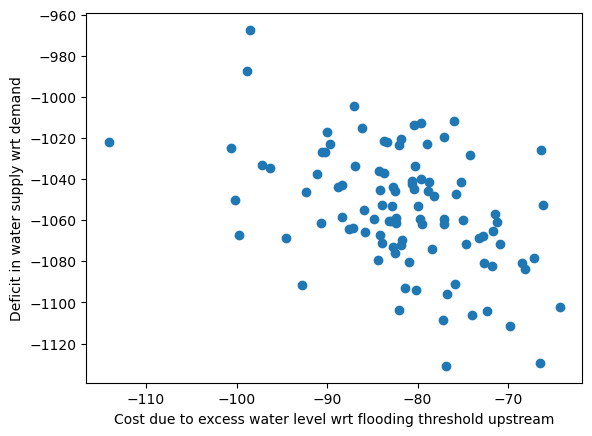

In [17]:
columns = ["objective_1", "objective_2"]

df = pd.read_csv("2obj_norm_lessPNoise.csv", usecols=columns)

plt.plot(df.objective_1, df.objective_2, 'o')
plt.xlabel('Cost due to excess water level wrt flooding threshold upstream')
plt.ylabel('Deficit in water supply wrt demand')
plt.show()

### Experiment with TD3 hyperparameters

- net_arch = [500]

opt for single layer NN

In [2]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers', policy_noise=0.002, noise_clip=0.005, net_arch=[500])

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650) #random ref_point, hv is not used in the algorithm so this does not matter for training

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [  -90.0921 -1047.2916] to CCS.
Adding value: [  -78.3286 -1002.1559] to CCS.
removed value [  -90.0921 -1047.2916]


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([  -78.3286, -1002.1559], dtype=float32)] CCS size: 1
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [  -76.1664 -1078.2339] to CCS.
Adding value: [  -88.0153 -1022.6454] to CCS.
Value [  -88.0153 -1022.6454] is dominated. Discarding.
Adding value: [  -77.4119 -1050.6255] to CCS.
Value [  -77.4119 -1050.6255] is dominated. Discarding.
W_corner: [array([1., 0.]), array([0.9724, 0.0276]), array([0., 1.])] W_corner size: 3
CCS: [array([  -78.3286, -1002.1559], dtype=float32), array([  -76.1664, -1078.2339], dtype=float32)] CCS size: 2
Next weight: [0.9724 0.0276]
Next weight vector: [0.9724 0.0276]
Adding value: [  -77.6765 -1018.5369] to CCS.
Value [  -77.6765 -1018.5369] is dominated. Discarding.
Adding value: [  -74.0643 -1056.9067] to CCS.
removed value [  -76.1664 -1078.2339]
Adding value: [  -90.004  -1005.2656] to CCS.
Value [  -90.004  -1005.2656] is dominated. Discarding.
Adding value: [  -8

eval/Mean Utility - GPI,▆▄▂█▅▃█▁▆▃
iteration,▁▂▃▃▄▅▆▆▇█
eval/Mean Utility - GPI,-569.59718
iteration,10


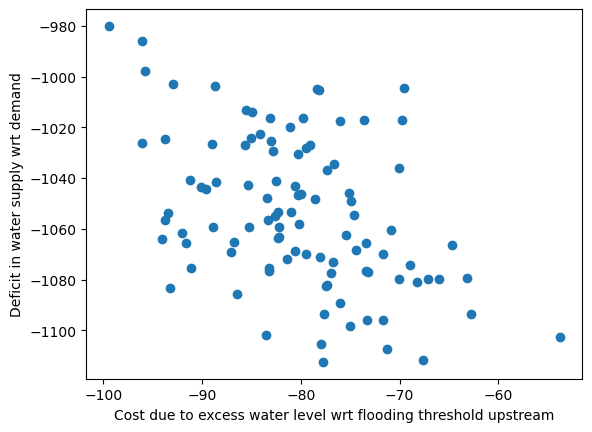

In [2]:
columns = ["objective_1", "objective_2"]

df = pd.read_csv("2obj_norm_lessPNoise_Hlayer500.csv", usecols=columns)

plt.plot(df.objective_1, df.objective_2, 'o')
plt.xlabel('Cost due to excess water level wrt flooding threshold upstream')
plt.ylabel('Deficit in water supply wrt demand')
plt.show()

When looking at the resulting solution set, the returns have improved slightly. We'll try to experiment more with the hidden layer configuration.

## PGMORL

Works for continuous action an observation spaces.

Use the results of this algorithm to get a comparison for the GPI-ls algo.

Test on normalized env first to observe performance

In [8]:
from morl_baselines.multi_policy.pgmorl.pgmorl import PGMORL

#env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=100)

PGAgent = PGMORL('water-reservoir-v0', origin=np.array([-1000.0,-1000.0]), log=False) ## log=True yields error because self.env is None...

PGAgent.train(100000, np.array([-1000.0,-1000.0]))

c:\Users\liamm\anaconda3\lib\site-packages\gymnasium\wrappers\monitoring\video_recorder.py:182: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
Exception ignored in: <function VideoRecorder.__del__ at 0x000001E3678AE790>
Traceback (most recent call last):
  File "c:\Users\liamm\anaconda3\lib\site-packages\gymnasium\wrappers\monitoring\video_recorder.py", line 181, in __del__
    if not self._closed:
AttributeError: 'VideoRecorder' object has no attribute '_closed'
c:\Users\liamm\anaconda3\lib\site-packages\gymnasium\wrappers\record_video.py:79: UserWarning: WARN: Overwriting existing videos at c:\Users\liamm\water-resource-management\GPI\videos\PGMORL_0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\liamm\anaconda3\lib\site-packages\gymnasium\wrappers\monitoring\video_recorder.py:62: UserWarning: WARN: Disabling video rec

Warmup phase - sampled weights: [[0.  1. ]
 [0.2 0.8]
 [0.4 0.6]
 [0.6 0.4]
 [0.8 0.2]
 [1.  0. ]]
Warmup iteration #0
SPS: 1130
SPS: 604
SPS: 420
SPS: 321
SPS: 257
SPS: 216
Warmup iteration #1
SPS: 372
SPS: 323
SPS: 289
SPS: 260
SPS: 237
SPS: 218
Warmup iteration #2
SPS: 302
SPS: 279
SPS: 256
SPS: 240
SPS: 227
SPS: 211
Warmup iteration #3
SPS: 262
SPS: 245
SPS: 230
SPS: 217
SPS: 208
SPS: 200
Warmup iteration #4
SPS: 241
SPS: 233
SPS: 225
SPS: 218
SPS: 211
SPS: 203
Warmup iteration #5
SPS: 233
SPS: 224
SPS: 215
SPS: 208
SPS: 201
SPS: 196
Warmup iteration #6
SPS: 223
SPS: 218
SPS: 213
SPS: 208
SPS: 203
SPS: 196
Warmup iteration #7
SPS: 217
SPS: 209
SPS: 204
SPS: 199
SPS: 194
SPS: 190
Warmup iteration #8
SPS: 209
SPS: 204
SPS: 200
SPS: 196
SPS: 192
SPS: 188
Warmup iteration #9
SPS: 205
SPS: 201
SPS: 197
SPS: 194
SPS: 190
SPS: 187
Warmup iteration #10
SPS: 202
SPS: 199
SPS: 196
SPS: 193
SPS: 190
SPS: 187
Warmup iteration #11
SPS: 201
SPS: 198
SPS: 196
SPS: 193
SPS: 190
SPS: 188
Warmup ite

In [13]:
from morl_baselines.common.evaluation import eval_mo

env = mo_gym.make('water-reservoir-v0')

for a in PGAgent.archive.individuals:
        scalarized, discounted_scalarized, reward, discounted_reward = eval_mo(
            agent=a, env=env, w=np.array([0.7, 0.3]), render=True
        )
        print(f"Agent #{a.id}")
        print(f"Scalarized: {scalarized}")
        print(f"Discounted scalarized: {discounted_scalarized}")
        print(f"Vectorial: {reward}")
        print(f"Discounted vectorial: {discounted_reward}")

Agent #1
Scalarized: -6570.624627304077
Discounted scalarized: -5169.428950679302
Vectorial: [-8888.3002 -1162.7148]
Discounted vectorial: [-6983.8663  -935.7418]


c:\Users\liamm\anaconda3\lib\site-packages\mo_gymnasium\envs\water_reservoir\dam_env.py:158: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. mo_gym.make("water-reservoir-v0", render_mode="rgb_array")
  gym.logger.warn(
